In [5]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

## Dữ liệu

In [6]:
# RICE_URI = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Lua/gia_lua.csv"

In [7]:
df_rice = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/CaPhe/gia_cafe_den_2023.csv', encoding='ISO-8859-1')

In [8]:
df_rice.head()

,date,price
0,1/2/2007,21600.0
1,1/3/2007,22000.0
2,1/4/2007,21700.0
3,1/5/2007,22000.0
4,1/6/2007,22000.0


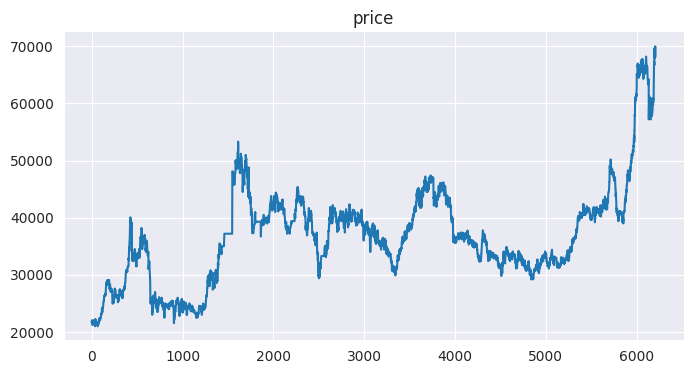

In [9]:
# @title EDA Data

from matplotlib import pyplot as plt
df_rice['price'].plot(kind='line', figsize=(8, 4), title='price')
plt.gca().spines[['top', 'right']].set_visible(False)

In [10]:
df_rice.set_index('date', inplace=True)

In [11]:
df_rice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6208 entries, 1/2/2007 to 12/31/2023
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   6208 non-null   float64
dtypes: float64(1)
memory usage: 97.0+ KB


### Xử lí outlier

<Axes: >

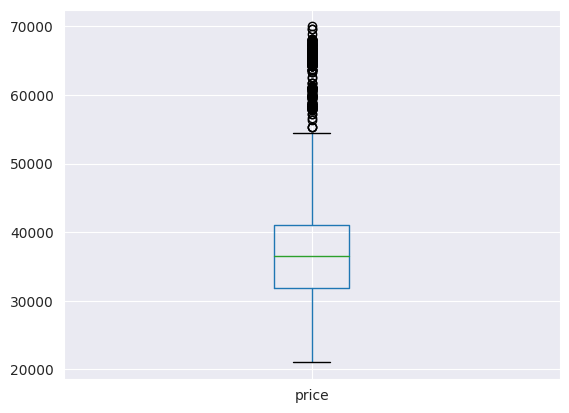

In [12]:
df_rice.boxplot()

In [13]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df_rice['price'].quantile(0.25)
Q3 = df_rice['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df_rice[(df_rice['price'] < lower_bound) | (df_rice['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df_rice.at[df_rice.index[0], 'price'] = min(max(df_rice.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df_rice.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df_rice.index[previous_date_index]
        previous_value = df_rice.loc[previous_date, 'price']
        df_rice.at[index, 'price'] = previous_value

Số lượng outlier: 233


<Axes: >

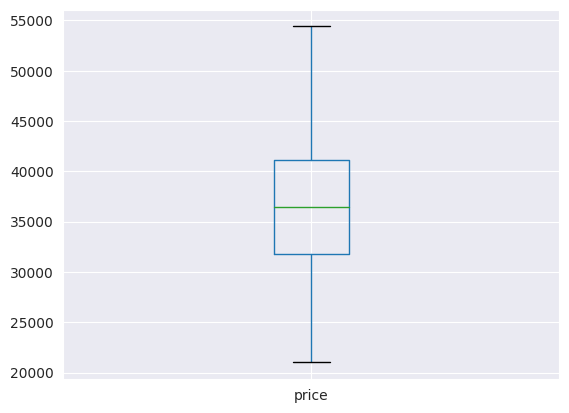

In [14]:
df_rice.boxplot()

<Axes: xlabel='date'>

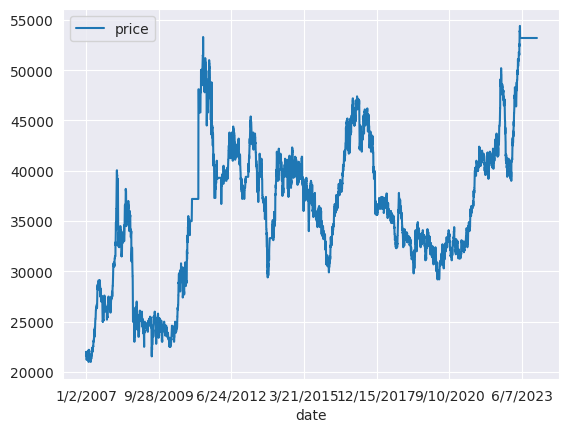

In [15]:
df_rice.plot()

### Smothing Data

In [16]:
df_rice = df_rice.rolling(45).mean()
df_rice = df_rice.dropna()

<Axes: xlabel='date'>

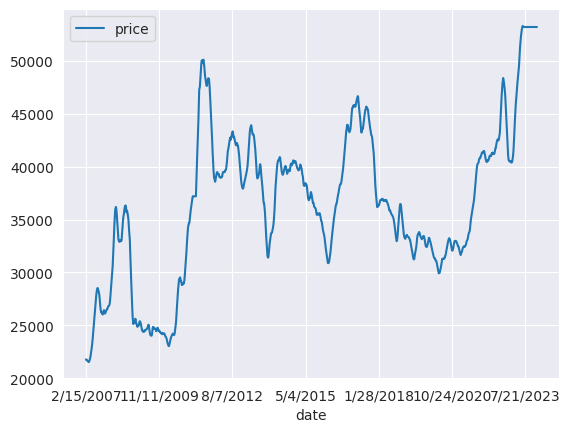

In [17]:
df_rice.plot()

# Kiểm tra tính dừng

In [18]:
def test_stationarity(timeseries):

    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=1).mean()
    movingSTD = timeseries.rolling(window=1).std()

    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)

    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

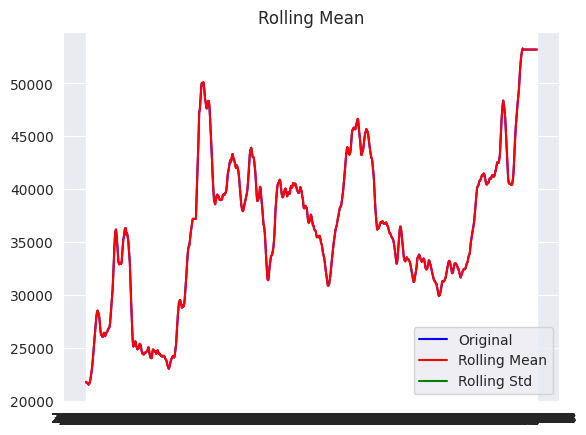

Results of Dickey Fuller Test:
Test Statistic                   -2.844252
p-value                           0.052225
#Lags Used                        9.000000
Number of Observations Used    6154.000000
Critical Value (1%)              -3.431413
Critical Value (5%)              -2.862010
Critical Value (10%)             -2.567020
dtype: float64


In [19]:
test_stationarity(df_rice.price)

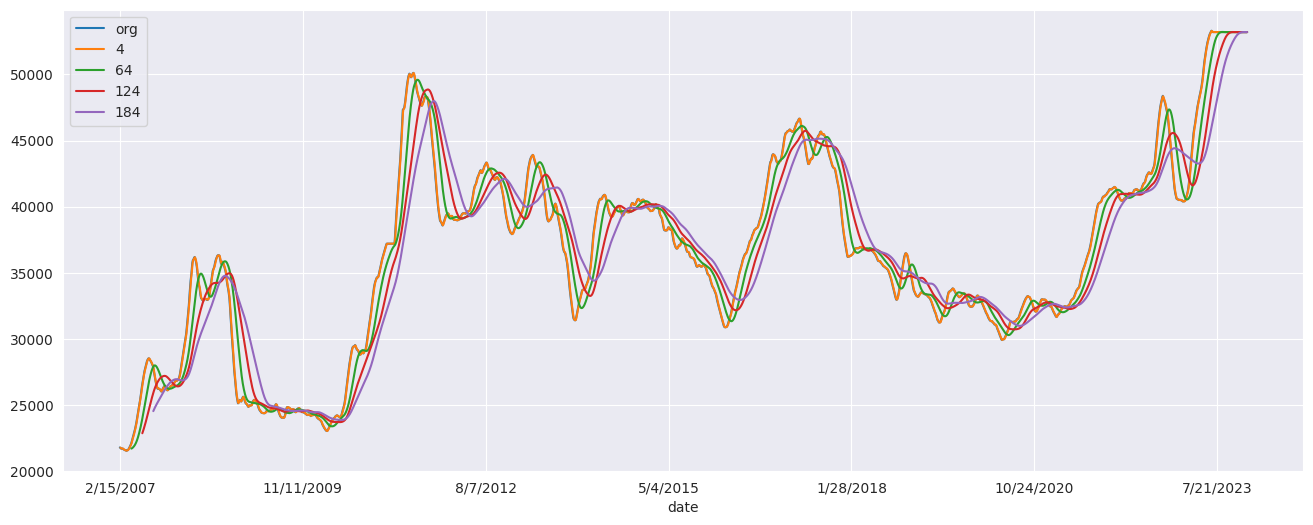

In [20]:
plt.figure(figsize=(16,6))
df_rice.price.plot(label="org")
for i in range(4,200,60):
    df_rice["price"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

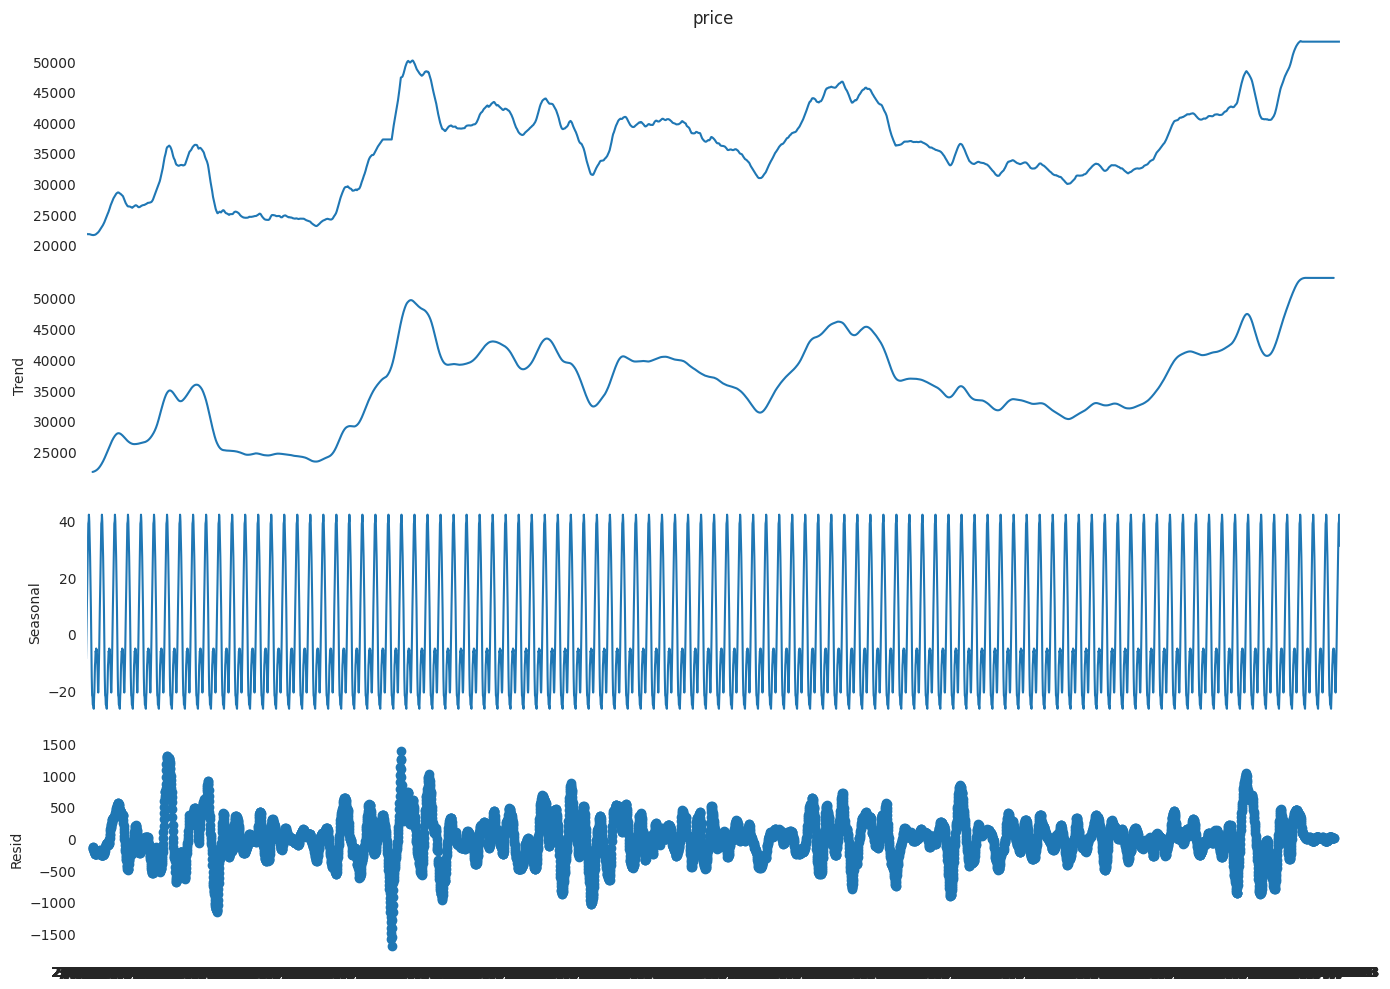

In [21]:
decompose_ts_add = seasonal_decompose(df_rice.price,period=64)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

In [22]:
from statsmodels.tsa.stattools import pacf
pacf(df_rice.price, nlags=10)

array([ 1.        ,  0.99936955, -0.05187208, -0.04854776, -0.04503304,
       -0.0422286 , -0.03944006, -0.03690019, -0.03430807, -0.0321425 ,
       -0.02986312])

In [23]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,6))
    tsa_plots.acf(df_rice.price, nlags=10)
    plt.show()

In [24]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series.dropna())
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [25]:
df1 = df_rice.price.copy()

### Các phương pháp thường được sử dụng

Sai phân (Diff): Để tính sai phân bậc một của chuỗi dữ liệu

Y_t​
 , công thức là:

 ΔYₜ = Yₜ - Yₜ₋₁


Sai phân theo mùa vụ (Seasonal Diff): Để tính sai phân theo mùa vụ của chuỗi dữ liệu với chu kỳ mùa vụ là
m (ví dụ: hàng năm)

ΔYₜ = Yₜ - Y_{t-m}


In [26]:
# create a differenced series
def difference(dataset, interval=1):
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)
  return diff

In [27]:
# invert differenced forecast
def inverse_difference(last_ob, value):
  return value + last_ob

In [28]:
diff = difference(df1, 60)

In [29]:
from matplotlib import pyplot

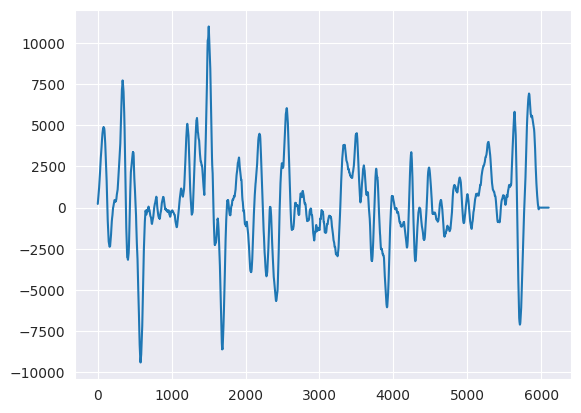

In [30]:
pyplot.plot(diff)
pyplot.show()

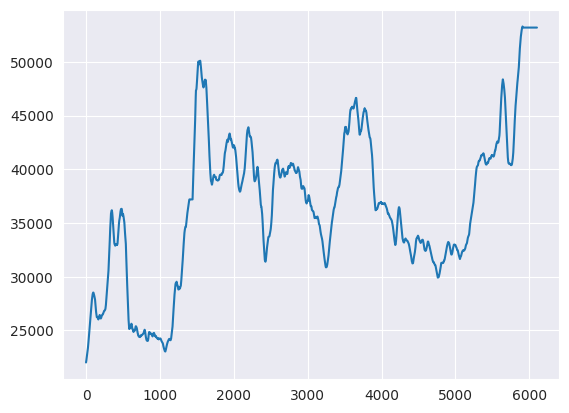

In [31]:
# invert the difference
inverted = [inverse_difference(df1[i], diff[i]) for i in range(len(diff))]
pyplot.plot(inverted)
pyplot.show()

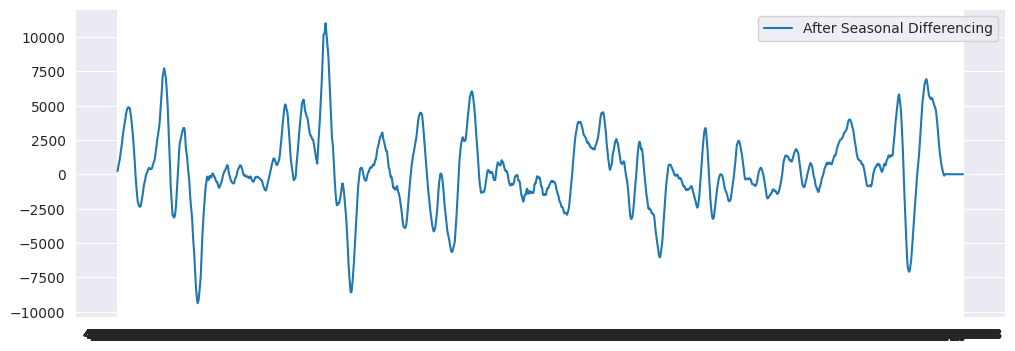

In [32]:
seasonal_differencing = df1 - df1.shift(60)
seasonal_differencing.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_differencing, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

In [33]:
def revert_tranform_seasonal(df):
  return df + df.shift(60)

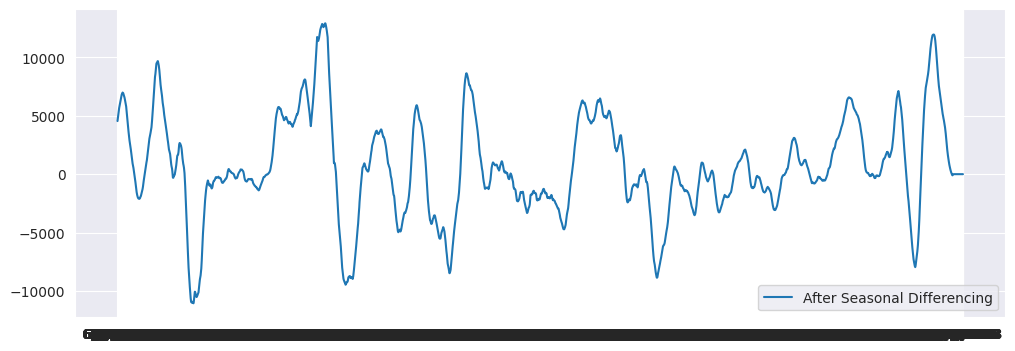

In [34]:
seasonal_revert = revert_tranform_seasonal(seasonal_differencing)
seasonal_revert.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_revert, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

<Axes: xlabel='date'>

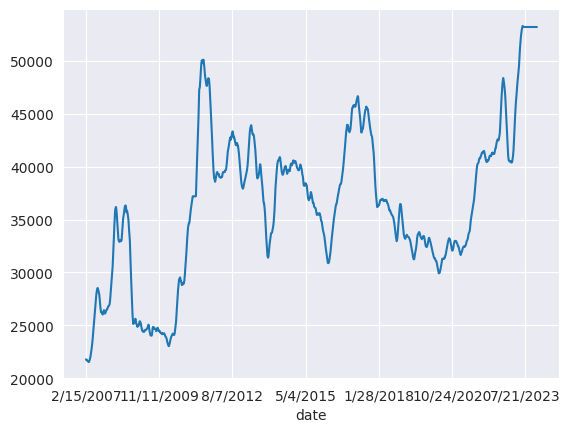

In [35]:
df1.plot()

### Log Scale Transformation

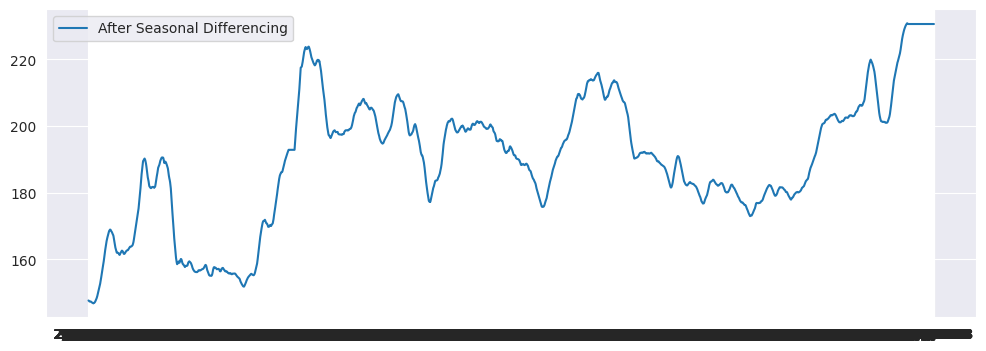

In [36]:
seasonal_box_plot = np.sqrt(df1)
seasonal_box_plot.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_box_plot, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

In [37]:
def revert_tranform_seasonal(df):
  return np.square(df)

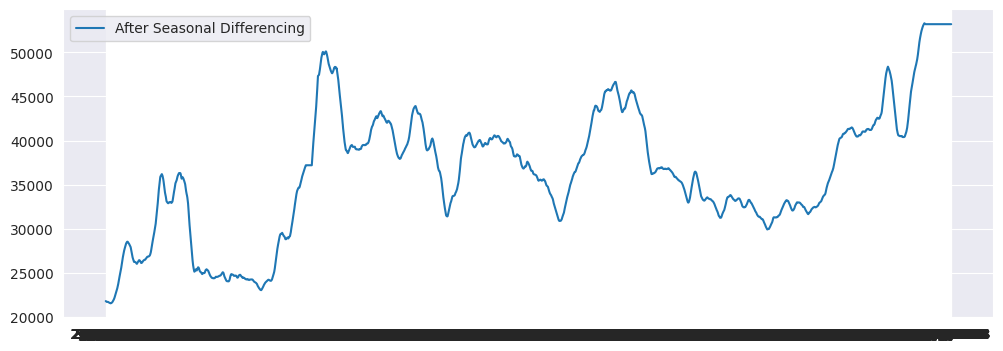

In [38]:
seasonal_revert = revert_tranform_seasonal(seasonal_box_plot)
seasonal_revert.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(seasonal_revert, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

In [39]:
adf_test(seasonal_box_plot)

Reject the null hypothesis
Data is stationary


In [40]:
seasonal_differencing.info()

<class 'pandas.core.series.Series'>
Index: 6104 entries, 4/16/2007 to 12/31/2023
Series name: price
Non-Null Count  Dtype  
--------------  -----  
6104 non-null   float64
dtypes: float64(1)
memory usage: 95.4+ KB


In [41]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.0 MB/s eta 0:00:00


In [42]:
df_rice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6164 entries, 2/15/2007 to 12/31/2023
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   6164 non-null   float64
dtypes: float64(1)
memory usage: 96.3+ KB


In [43]:
df1 = df1.copy()

In [44]:
# df1['price'] = df_rice["price"].rolling(60).mean()

In [45]:
df1

date
2/15/2007     21793.333333
2/16/2007     21786.666667
2/17/2007     21771.111111
2/18/2007     21762.222222
2/19/2007     21746.666667
                  ...     
12/27/2023    53200.000000
12/28/2023    53200.000000
12/29/2023    53200.000000
12/30/2023    53200.000000
12/31/2023    53200.000000
Name: price, Length: 6164, dtype: float64

In [46]:
df1 = df1.dropna()


In [47]:
df1.info()

<class 'pandas.core.series.Series'>
Index: 6164 entries, 2/15/2007 to 12/31/2023
Series name: price
Non-Null Count  Dtype  
--------------  -----  
6164 non-null   float64
dtypes: float64(1)
memory usage: 96.3+ KB


In [48]:
size = int(len(df1) * 0.8)
train_data = df1[:size]
test_data = df1[size:]

<Axes: xlabel='date'>

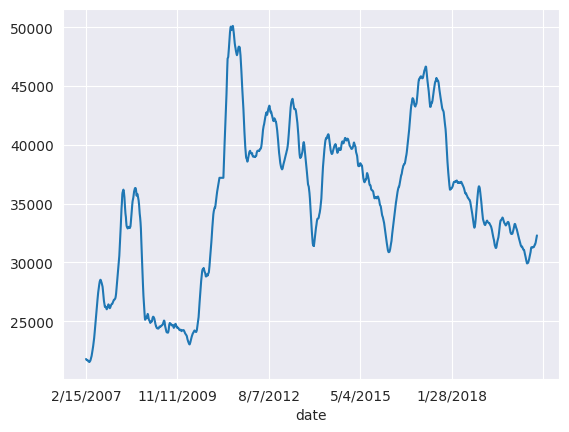

In [49]:
train_data.plot()

In [50]:
train_data =  train_data.diff()

In [51]:
train_data.info()
train_data = train_data.dropna()

<class 'pandas.core.series.Series'>
Index: 4931 entries, 2/15/2007 to 8/15/2020
Series name: price
Non-Null Count  Dtype  
--------------  -----  
4930 non-null   float64
dtypes: float64(1)
memory usage: 77.0+ KB


<Axes: xlabel='date'>

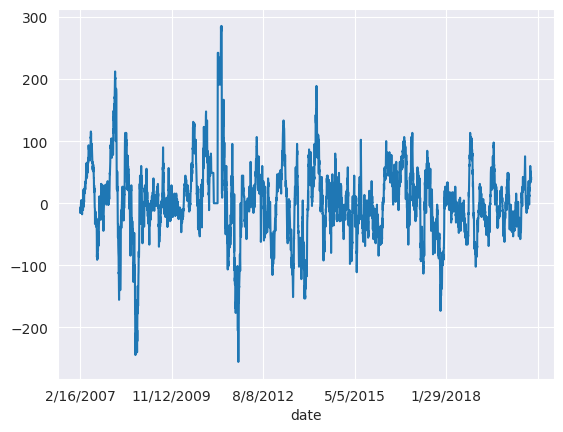

In [52]:
train_data.plot()

In [53]:
adf_test(train_data)

Reject the null hypothesis
Data is stationary


In [54]:
diff_data = train_data.copy()
diff_data.iloc[0] = train_data.iloc[0]

# Compute the cumulative sum to revert the diff transformation
reverted_data = diff_data.cumsum()

<Axes: xlabel='date'>

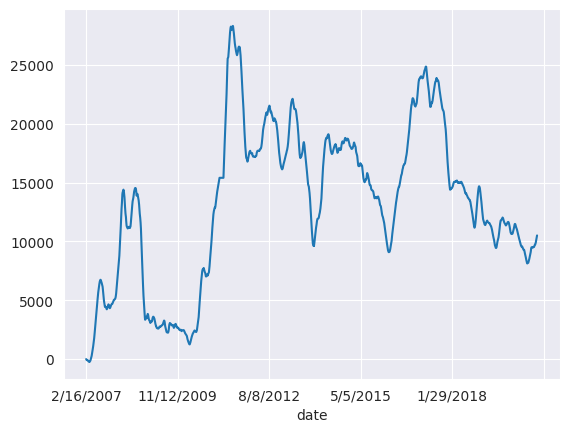

In [55]:
reverted_data.plot()

In [56]:
size

4931

In [57]:
train_data.values

array([ -6.66666667, -15.55555556,  -8.88888889, ...,  42.22222222,
        42.22222222,  37.77777778])

## ARIMA MODEL

Mô hình ARIMA: Dựa trên giả thuyết chuỗi dừng và phương sai sai số không đổi. Mô hình sử dụng đầu vào chính là những tín hiệu quá khứ của chuỗi được dự báo để dự báo nó. Các tín hiệu đó bao gồm: chuỗi tự hồi qui AR (auto regression) và chuỗi trung bình trượt MA (moving average). Hầu hết các chuỗi thời gian sẽ có xu hướng tăng hoặc giảm theo thời gian, do đó yếu tố chuỗi dừng thường không đạt được. Trong trường hợp chuỗi không dừng thì ta sẽ cần biến đổi sang chuỗi dừng bằng sai phân. Khi đó tham số đặc trưng của mô hình sẽ có thêm thành phần bậc của sai phân d và mô hình được đặc tả bởi 3 tham số ARIMA(p, d, q).


Xt=α1Xt−1+⋯+αpXt−p+εt+θ1εt−1+⋯+θqεt−q

Tham khảo: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html

In [58]:
import pmdarima as pm

model_arima = pm.auto_arima(train_data.values, start_p=3, start_q=3,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=39821.160, Time=15.71 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=54366.189, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=39849.777, Time=0.40 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=49027.802, Time=2.34 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=39844.701, Time=4.86 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=39793.841, Time=16.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=39846.500, Time=10.44 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=39846.285, Time=7.54 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=39846.179, Time=7.41 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=39849.279, Time=2.10 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=39844.519, Time=2.63 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=10.02 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=39801.029, Time=14.71 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit time: 94.525 seconds
         

Kiểm tra kết quả

In [59]:
n_periods = len(test_data)
fc, confint = model_arima.predict(n_periods=n_periods, return_conf_int=True, dynamic=True)
index_of_fc = np.arange(len(test_data), len(test_data.values) + n_periods)

In [60]:
import joblib
joblib.dump(model_arima, 'arima_gia_lua.joblib')

['arima_gia_lua.joblib']

In [61]:
from google.colab import files
files.download('arima_gia_lua.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [75]:
fc_series = pd.Series(fc, index=test_data.index)

In [63]:
test_data.info()

<class 'pandas.core.series.Series'>
Index: 1233 entries, 8/16/2020 to 12/31/2023
Series name: price
Non-Null Count  Dtype  
--------------  -----  
1233 non-null   float64
dtypes: float64(1)
memory usage: 19.3+ KB


<Axes: xlabel='date'>

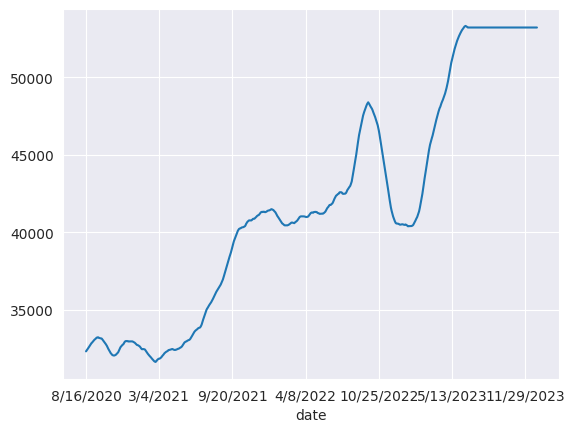

In [76]:
test_data.plot()

<Axes: xlabel='date'>

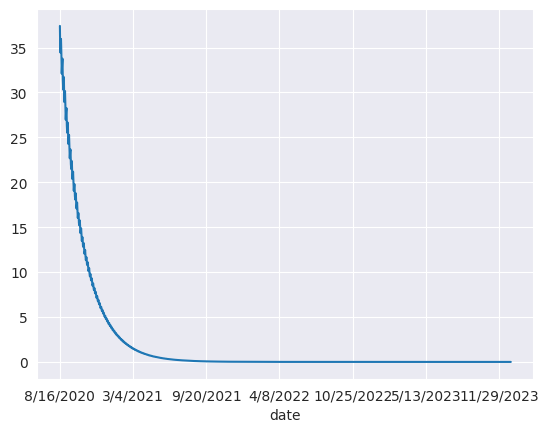

In [77]:
fc_series.plot()

<Axes: xlabel='date'>

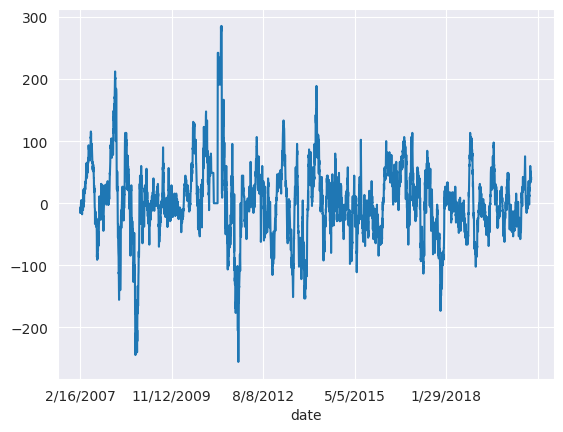

In [78]:
train_data.plot()

In [79]:
diff_data = fc_series.copy()

reverted_data = test_data.iloc[0] + diff_data.cumsum()
# Compute the cumulative sum to revert the diff transformation


<Axes: xlabel='date'>

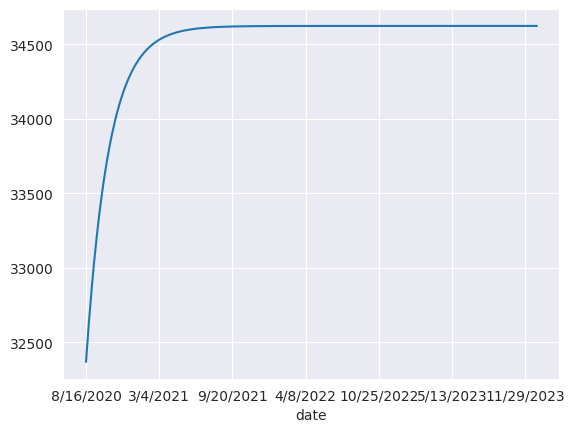

In [81]:
reverted_data.plot()

In [80]:
test_data

date
8/16/2020     32331.111111
8/17/2020     32364.444444
8/18/2020     32391.111111
8/19/2020     32424.444444
8/20/2020     32453.333333
                  ...     
12/27/2023    53200.000000
12/28/2023    53200.000000
12/29/2023    53200.000000
12/30/2023    53200.000000
12/31/2023    53200.000000
Name: price, Length: 1233, dtype: float64

<Axes: xlabel='date'>

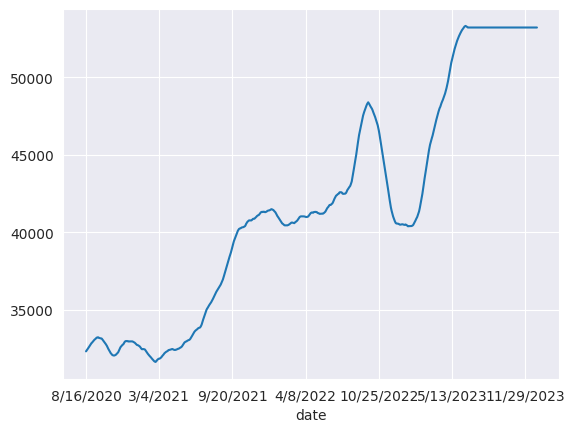

In [82]:
df1[int(len(df1)*0.8):].plot()

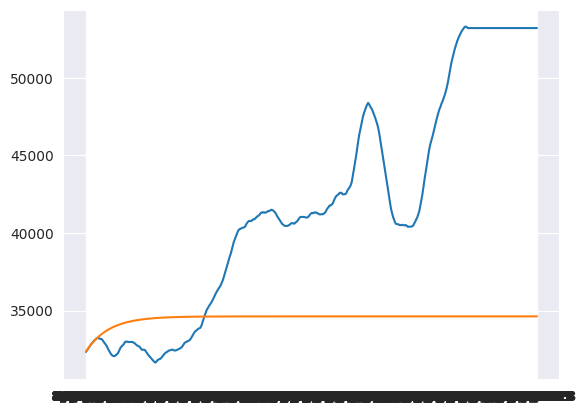

In [83]:
#plot the predictions for validation set
# plt.plot(train_data_inverse, label='Train')
plt.plot(test_data, label='Valid')
plt.plot(reverted_data, label='Prediction')
plt.show()

In [72]:
rmse = sqrt(mean_squared_error(test_data.values, reverted_data))
rmse

32363.573525449603

In [73]:
from sklearn.metrics import mean_absolute_percentage_error

def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast) * 100  # MAPE     # ME
    rmse = np.mean((forecast - actual)**2)**.5  # RMS
    return({'mape':mape, 'rmse':rmse})

In [74]:
forecast_accuracy(test_data.values, reverted_data.values)

{'mape': 42.94768755903077, 'rmse': 32363.573525449603}